<a href="https://colab.research.google.com/github/simonacarusooo/Algorithms-for-Massive-Datasets/blob/main/ADM_SPARK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LINK ANALYSIS IN SPARK


##  1. Data Import

For the purpose of the analysis, the dataframe has been reduced to 4 columns: 


*   customer_id
*   review_id
* product_id
* product_title


Furthermore, just 100000 reviews of product category "Electronics" has been considered


---





In [3]:
import csv
import os 
import pandas as pd   
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import os
os.environ['KAGGLE_USERNAME'] = "simonacaruso99"
os.environ['KAGGLE_KEY'] = "xxxxxx"
!kaggle datasets download -d cynthiarempel/amazon-us-customer-reviews-dataset

100% 21.0G/21.0G [03:25<00:00, 91.4MB/s]
100% 21.0G/21.0G [03:25<00:00, 109MB/s] 


In [5]:
import zipfile

zip_file = zipfile.ZipFile('/content/amazon-us-customer-reviews-dataset.zip')

df = pd.DataFrame({'marketplace': pd.Series([], dtype='str'),
              'customer_id': pd.Series([], dtype='str'),
              'review_id': pd.Series([], dtype='str'),
              'product_id': pd.Series([], dtype='str'),
              'product_parent': pd.Series([], dtype='str'),
              'product_title': pd.Series([], dtype='str'),
              'product_category': pd.Series([], dtype='str'),
              'star_rating': pd.Series([], dtype='int'),
              'helpful_votes': pd.Series([], dtype='int'),
              'total_votes': pd.Series([], dtype='int'),
              'vine': pd.Series([], dtype='str'),
              'verified_purchase': pd.Series([], dtype='str'),
              'review_headline': pd.Series([], dtype='str'),
              'review_body': pd.Series([], dtype='str'),
              'review': pd.Series([], dtype='str'),
              'review_date': pd.Series([], dtype='float')})


filenames = ['amazon_reviews_us_Electronics_v1_00.tsv']

for filename in filenames:
    with zip_file.open(filename) as f:
        size = 100000
        df = pd.read_csv(f, sep='\t', header=0, quoting=csv.QUOTE_NONE, nrows=size)

df = df.loc[:, ['customer_id', 'review_id', 'product_id','product_title']]
print(df.shape)
df.head()

(100000, 4)


,customer_id,review_id,product_id,product_title
0,41409413,R2MTG1GCZLR2DK,B00428R89M,yoomall 5M Antenna WIFI RP-SMA Female to Male ...
1,49668221,R2HBOEM8LE9928,B000068O48,"Hosa GPM-103 3.5mm TRS to 1/4"" TRS Adaptor"
2,12338275,R1P4RW1R9FDPEE,B000GGKOG8,Channel Master Titan 2 Antenna Preamplifier
3,38487968,R1EBPM82ENI67M,B000NU4OTA,LIMTECH Wall charger + USB Hotsync & Charging ...
4,23732619,R372S58V6D11AT,B00JOQIO6S,Skullcandy Air Raid Portable Bluetooth Speaker


In [6]:
!pip install pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

conf = SparkConf().setAppName("Amazon Customer Reviews").setMaster("local[*]")
sc = SparkContext.getOrCreate(conf=conf)
spark = SparkSession.builder.appName("Amazon Customer Reviews").getOrCreate()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=c9acceac5e7b6ea0c2914e9e385022d9f7979334a112d0a080056dcd2364beb3
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


## 2. Data exploration

There are not Null values, so the entire dataset can be used for the analysis


---



In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   customer_id    100000 non-null  int64 
 1   review_id      100000 non-null  object
 2   product_id     100000 non-null  object
 3   product_title  100000 non-null  object
dtypes: int64(1), object(3)
memory usage: 3.1+ MB


Taking the top 20 products identified by *id* and by *title*, it is possible to note that the number of reviews does not match. This is due to the fact that products with different ids have the same name. Given that each id corresponds to a different page in Amazon, the analysis has been made using *product_id* as the product identifier


---




In [16]:
n = 20
print("Most reviewed products identified by id:")
df['product_id'].value_counts()[:n]

Most reviewed products identified by id:


B00F5NE2KG    513
B003EM8008    467
B003L1ZYYM    455
B000WYVBR0    289
B00IF70T4M    271
B008KVUAGU    239
B0012S4APK    238
B00RBIC1IS    237
B0001FTVEK    215
B00NH126Q0    209
B00NC3SU6I    206
B00NXET2MM    204
B00MITLPX2    179
B003WGRUQQ    175
B008GVOVK0    173
B00K589F8A    173
B00WK47VEW    171
B00870ZHCQ    166
B00RJBW9AM    162
B00GZC35YK    161
Name: product_id, dtype: int64

In [17]:
print("Most reviewed products identified by title:")
df['product_title'].value_counts()[:n]

Most reviewed products identified by title:


Panasonic ErgoFit In-Ear Earbud Headphone                                                                                                                                                                        1120
Bluetooth Speaker, DKnight Magicbox Ultra-Portable Wireless Bluetooth Speaker Powerful Sound with build in Microphone, Works for Cellphone                                                                        778
AmazonBasics High-Speed HDMI Cable - 6.5 Feet (2 Meters) Supports Ethernet, 3D, 4K and Audio Return                                                                                                               664
AmazonBasics High Speed HDMI Cable                                                                                                                                                                                440
1byone Amplified HDTV Antenna, with Detachable Amplifier Signal Booster for the Highest Performance and 10 Feet Coaxial Cable-Black             

In [25]:
df[df["product_id"]=="B00F5NE2KG"]

,customer_id,review_id,product_id,product_title
615,8707213,R13I45DVPTZ4RD,B00F5NE2KG,"Bluetooth Speaker, DKnight Magicbox Ultra-Port..."
922,20251357,R2D5TH80MI5DYL,B00F5NE2KG,"Bluetooth Speaker, DKnight Magicbox Ultra-Port..."
965,28148518,R2W5D3QRIT9ZUX,B00F5NE2KG,"Bluetooth Speaker, DKnight Magicbox Ultra-Port..."
1019,11353946,RH453VRS3J5OE,B00F5NE2KG,"Bluetooth Speaker, DKnight Magicbox Ultra-Port..."
1047,13092882,R1IM3R4DDG3XRD,B00F5NE2KG,"Bluetooth Speaker, DKnight Magicbox Ultra-Port..."
...,...,...,...,...
99606,155144,R20IOL01SM7YSG,B00F5NE2KG,"Bluetooth Speaker, DKnight Magicbox Ultra-Port..."
99649,48809263,R21VFYCJV8EYO4,B00F5NE2KG,"Bluetooth Speaker, DKnight Magicbox Ultra-Port..."
99794,13521172,R3RUMYYP53S0PF,B00F5NE2KG,"Bluetooth Speaker, DKnight Magicbox Ultra-Port..."
99810,10860763,R2RMZAO36XSCEI,B00F5NE2KG,"Bluetooth Speaker, DKnight Magicbox Ultra-Port..."


In [26]:
df[(df["product_id"]=="B00F5NE2KG") & (df["product_title"]!= "Bluetooth Speaker, DKnight Magicbox Ultra-Portable Wireless Bluetooth Speaker Powerful Sound with build in Microphone, Works for Cellphone")]

,customer_id,review_id,product_id,product_title


<Axes: >

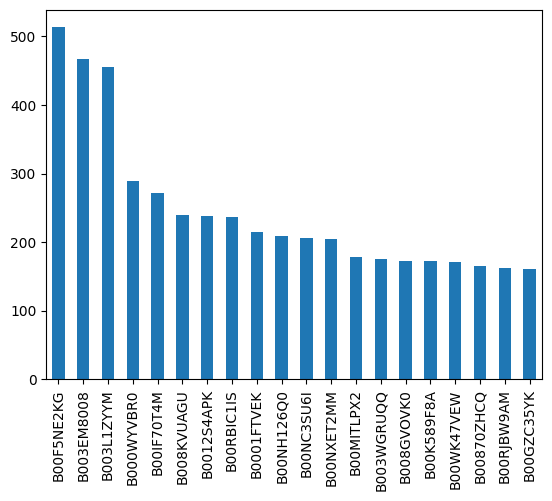

In [29]:
df['product_id'].value_counts()[:n].plot.bar()

## 3. Link Analysis

The analysis can be done on massive dataset and to save space and time the dataframe is converted in a Spark Dataframe

---



In [27]:
df = df.astype(str)
sdf = spark.createDataFrame(df)
sdf.show()

+-----------+--------------+----------+--------------------+
|customer_id|     review_id|product_id|       product_title|
+-----------+--------------+----------+--------------------+
|   41409413|R2MTG1GCZLR2DK|B00428R89M|yoomall 5M Antenn...|
|   49668221|R2HBOEM8LE9928|B000068O48|Hosa GPM-103 3.5m...|
|   12338275|R1P4RW1R9FDPEE|B000GGKOG8|Channel Master Ti...|
|   38487968|R1EBPM82ENI67M|B000NU4OTA|LIMTECH Wall char...|
|   23732619|R372S58V6D11AT|B00JOQIO6S|Skullcandy Air Ra...|
|   21257820|R1A4514XOYI1PD|B008NCD2LG|Pioneer SP-BS22-L...|
|    3084991|R20D9EHB7N20V6|B00007FGUF|C2G/Cables to Go ...|
|    8153674|R1WUTD8MVSROJU|B00M9V2RMM|COOLEAD-HDMI Swit...|
|   52246189|R1QCYLT25812DM|B00J3O9DYI|Philips Wireless ...|
|   41463864| R904DQPBCEM7A|B00NS1A0E4|PlayStation 3 3D ...|
|    2781942|R1DGA6UQIVLKZ7|B007B5V092|JVC HAFR201A Xtre...|
|     707292| RLQT3V8SMNIBH|B00IODHGVG|Sylvania Alarm Cl...|
|   31463514|R3T9GZS2TMXZGM|B0035PBHX6|Coby 8 GB 1.8-Inc...|
|   33475055|R24HVAEYP5P

In this first step, customers who released at least two reviews have been identified and for each of them the corresponding products are listed


---



In [33]:
customer_review = sdf.rdd.map(lambda x: (x[0], x[2]))\
                         .groupByKey().map(lambda x : (x[0], list(x[1]))).filter(lambda x: len(x[1])>=2)

In [34]:
print("(Customer id, [product id]): ")
for cr in customer_review.take(20):
    print(cr)

(Customer id, [product id]): 
('2781942', ['B007B5V092', 'B004S7Q8CA'])
('31463514', ['B0035PBHX6', 'B002MAPS6W'])
('42944532', ['B012VIWG28', 'B00ZWNYF7E', 'B00146E50U', 'B00YDVY34Q'])
('15241735', ['B00ESM3ZHG', 'B00JBRZ7U6'])
('40862185', ['B007SP2CO2', 'B004QK7HI8'])
('52886527', ['B005K2TXMO', 'B005920DVA'])
('28453953', ['B000HDONV2', 'B003L1ZYYW', 'B003XM1WE0', 'B005LJQNQU', 'B00269SXT8', 'B002TKS0S8'])
('11007967', ['B000N5YF9Y', 'B007WR0CHU'])
('46780686', ['B00DDULUIA', 'B00LT3ESZA', 'B0077V88V8'])
('2821382', ['B00B20M8CU', 'B00KVVBF7A'])
('31364444', ['B00PLCMZ8M', 'B00H7KD4T0', 'B0029U2XH2', 'B00F0WNWZI'])
('37536631', ['B00EKTN01S', 'B00KO99GB6', 'B00LT3ESZA', 'B00OH95V8Q'])
('4649728', ['B00QOPG5MC', 'B00EPP5ZSS'])
('50434152', ['B003OIJHPY', 'B001CROHU4'])
('34441121', ['B008R6WVEW', 'B0099UWHH6', 'B00027BU46'])
('42495213', ['B0089NLSGU', 'B0081ZBNI4'])
('34985475', ['B00CJHXY0U', 'B000WYVBR0'])
('31207284', ['B00LBNJANS', 'B000O5N5AI'])
('37228369', ['B00EKTN01S', 'B0

Products are combined in non ordered tuples. 

Tuples correspond to the edges, while the distinct products in the tuples are the nodes


---



In [35]:
import itertools
def combination(row):
    l = row[1]
    k = row[0]
    res1 = [(v[0], v[1]) for v in itertools.combinations(l, 2)]
    to_add = []
    for x in res1:
        to_add.append(tuple(reversed(x)))
    return (res1+to_add)

In [36]:
edges = customer_review.map(lambda x: combination(x)).flatMap(lambda l: l)

print("Tuples of products reviewed at least once by the same customer id:")
for e in edges.take(20):
    print(e)

Tuples of products reviewed at least once by the same customer id:
('B007B5V092', 'B004S7Q8CA')
('B004S7Q8CA', 'B007B5V092')
('B0035PBHX6', 'B002MAPS6W')
('B002MAPS6W', 'B0035PBHX6')
('B012VIWG28', 'B00ZWNYF7E')
('B012VIWG28', 'B00146E50U')
('B012VIWG28', 'B00YDVY34Q')
('B00ZWNYF7E', 'B00146E50U')
('B00ZWNYF7E', 'B00YDVY34Q')
('B00146E50U', 'B00YDVY34Q')
('B00ZWNYF7E', 'B012VIWG28')
('B00146E50U', 'B012VIWG28')
('B00YDVY34Q', 'B012VIWG28')
('B00146E50U', 'B00ZWNYF7E')
('B00YDVY34Q', 'B00ZWNYF7E')
('B00YDVY34Q', 'B00146E50U')
('B00ESM3ZHG', 'B00JBRZ7U6')
('B00JBRZ7U6', 'B00ESM3ZHG')
('B007SP2CO2', 'B004QK7HI8')
('B004QK7HI8', 'B007SP2CO2')


In [37]:
print("Number of edges:", edges.count())
print("Number of nodes:", edges.groupByKey().count())

nodes = edges.groupByKey().count()

Number of edges: 56144
Number of nodes: 11870


For each node, the number of outgoing connections to other nodes is computed


---


In [38]:
id2degree = edges.countByKey()
id2degree_list = sorted(id2degree.items(), key=lambda x: x[1], reverse=True)

print("Out degree for 20 different nodes:")
for e in id2degree_list [:20]:
    print(e)

Out degree for 20 different nodes:
('B003L1ZYYM', 352)
('B000J2EN4S', 173)
('B003EM8008', 163)
('B000WYVBR0', 162)
('B00BEWF4R2', 154)
('B0012S4APK', 150)
('B001GTT0VO', 148)
('B00870ZHCQ', 139)
('B0002L5R78', 134)
('B0052SCU8U', 131)
('B000IJY8DS', 129)
('B006LW0W5Y', 129)
('B008KVUAGU', 114)
('B001TH7GSW', 110)
('B00DDULUIA', 109)
('B003L1ZYYW', 107)
('B006U3O566', 105)
('B003ZDNZSI', 104)
('B001EPVOQY', 96)
('B00FX6ST8G', 91)


The probabilities of going from one node to the other is calculated. If the probability is equal to one, it means that a node has only one outgoing link. 


---


In [41]:
P = edges.map(lambda x:(x[0],x[1],1/id2degree[x[0]]))  #(i,j,W) where i: starting node, j: end node, W: probaility from i to j
PT = P.map(lambda x: (x[1],x[0],x[2])) #(j,i,W) it's like considering the matrix by columns (for the multiplication by the vector)

print("First 20 matrix entries:")
for p in PT.take(20):
    print(p)

First 20 matrix entries:
('B004S7Q8CA', 'B007B5V092', 1.0)
('B007B5V092', 'B004S7Q8CA', 0.14285714285714285)
('B002MAPS6W', 'B0035PBHX6', 0.2)
('B0035PBHX6', 'B002MAPS6W', 0.03571428571428571)
('B00ZWNYF7E', 'B012VIWG28', 0.1)
('B00146E50U', 'B012VIWG28', 0.1)
('B00YDVY34Q', 'B012VIWG28', 0.1)
('B00146E50U', 'B00ZWNYF7E', 0.2)
('B00YDVY34Q', 'B00ZWNYF7E', 0.2)
('B00YDVY34Q', 'B00146E50U', 0.25)
('B012VIWG28', 'B00ZWNYF7E', 0.2)
('B012VIWG28', 'B00146E50U', 0.25)
('B012VIWG28', 'B00YDVY34Q', 0.045454545454545456)
('B00ZWNYF7E', 'B00146E50U', 0.25)
('B00ZWNYF7E', 'B00YDVY34Q', 0.045454545454545456)
('B00146E50U', 'B00YDVY34Q', 0.045454545454545456)
('B00JBRZ7U6', 'B00ESM3ZHG', 1.0)
('B00ESM3ZHG', 'B00JBRZ7U6', 1.0)
('B004QK7HI8', 'B007SP2CO2', 0.06666666666666667)
('B007SP2CO2', 'B004QK7HI8', 0.03125)


The initial random walk vector is calculated. In the first iteration, the probability of being in one node is the same as being in any other node


---

In [40]:
p = 1/(nodes) 
products = customer_review.flatMap(lambda x: x[1]).collect() #products are listed

#a product dictionary has been created: 
#in this way each product corresponds to the key, and the value is the corresponding probability
pdiz = {}
for prod in products:
    pdiz[prod] = p

The values of the "matrix" PT are multiplied by the random walk vector and the result is another vector which will multiplicate again the PT matrix. After a certain number of iteration the vectors will converge


---




In [42]:
for i in range(100):
    new_p = PT.map(lambda x:(x[0],(x[2]*pdiz[x[1]])))\
              .reduceByKey(lambda x,y: x+y)\
              .collect()
    for idx,prb in new_p:
        pdiz[idx] = prb

In [43]:
pdiz_sort = sorted(pdiz.items(), key=lambda x:x[1], reverse=True) 

Products are sorted based on their PageRank value


---




In [45]:
for pr in range(len(pdiz_sort[:20])):
    print("PageRank value: ", pdiz_sort[pr][1], "- Product: ", pdiz_sort[pr][0])

PageRank value:  0.005213729578490573 - Product:  B003L1ZYYM
PageRank value:  0.002562183240016608 - Product:  B000J2EN4S
PageRank value:  0.0024141454491018993 - Product:  B003EM8008
PageRank value:  0.002399413031408523 - Product:  B000WYVBR0
PageRank value:  0.0022806791316289637 - Product:  B00BEWF4R2
PageRank value:  0.0022216503999907696 - Product:  B0012S4APK
PageRank value:  0.002191427030863916 - Product:  B001GTT0VO
PageRank value:  0.00205903340446627 - Product:  B00870ZHCQ
PageRank value:  0.001984874626185207 - Product:  B0002L5R78
PageRank value:  0.0019405194487864608 - Product:  B0052SCU8U
PageRank value:  0.001910877916047343 - Product:  B006LW0W5Y
PageRank value:  0.001910816360020033 - Product:  B000IJY8DS
PageRank value:  0.0016886603311700693 - Product:  B008KVUAGU
PageRank value:  0.0016289205192776411 - Product:  B001TH7GSW
PageRank value:  0.0016141132788244617 - Product:  B00DDULUIA
PageRank value:  0.001584759171379623 - Product:  B003L1ZYYW
PageRank value:  0

In [44]:
id_title = sdf.rdd.map(lambda x: (x[2], x[3]))\
                .reduceByKey(lambda x, y: x)\
                .collectAsMap()


In [48]:
for item in pdiz_sort[:20]:
    product_id = item[0]
    page_rank_value = item[1]
    product_title = id_title.get(product_id)
    print("PageRank value:", page_rank_value, "- Product:", product_title)

PageRank value: 0.005213729578490573 - Product: AmazonBasics High-Speed HDMI Cable - 6.5 Feet (2 Meters) Supports Ethernet, 3D, 4K and Audio Return
PageRank value: 0.002562183240016608 - Product: Belkin 6-Outlet Home and Office Power Strip Surge Protector with 4-Foot Power Cord, 720 Joules (BE106000-04)
PageRank value: 0.0024141454491018993 - Product: Panasonic ErgoFit In-Ear Earbud Headphone
PageRank value: 0.002399413031408523 - Product: VideoSecu ML531BE TV Wall Mount for most 22"-55" LED LCD Plasma Flat Screen Monitor up to 88 lb VESA 400x400 with Full Motion Swivel Articulating 20 in Extension Arm, HDMI Cable & Bubble Level WP5
PageRank value: 0.0022806791316289637 - Product: CABTE High speed HDMI 1.4 HDMI cable 10ft 1080p with mesh&filters supports 3D&blue ray
PageRank value: 0.0022216503999907696 - Product: Cheetah APTMM2B TV Wall Mount for 20-75" TVs up to VESA 600 and 165lbs, and fits 16” And 24” Wall Studs, and includes a Tilt TV Bracket, a 10' Twisted Veins HDMI Cable and a 